# Create Gaussian random fields with lya survey geometry to compute $C_{\ell}(k)$
- [x] generate GRFs with Lya bias and beta
- [x] draw skewers through box
- [x] FFT each skewer and construct $\delta_{2D}$ matrix
    - [x] do discrete version where multiplication of $\exp(i\mathbf(k)\mathbf{\chi})$
- [x] matrix of shape: (N_qso x N_kbins), so that in row i: ($\delta_F(k_0), \dots,\delta_F(k_N)$)
- [x] compute $$a_{\ell m}(\mathbf{k}) = \sum_j^{N_q} \delta_{2D}(x,y,z,k_i)Y_{\ell m}^{\ast}(x,y,j)$$
- [x] compute $$\hat{C}_{\ell}(k_i) = \texttt{hp.alm2cl}(a_lm(k_i))$$
- [ ] compute theory Eq. 2.13 in draft

In [5]:
3

3

In [6]:
%matplotlib inline
import numpy as np
from matplotlib_params_file import *
from numba import jit
import multiprocessing as mp
import healpy as hp
from scipy.linalg import dft
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, legendre
from scipy.integrate import simps

#camb
import camb 
from camb import model, initialpower

# GRFs
import GRF_class as my_GRF

## create GRFs
- set `add_rsd=True' if you want to add RSD

In [7]:
GRF = my_GRF.PowerSpectrumGenerator(add_rsd=False)

Fundamental mode k_f= 0.004553032831289555
max mode k_f= 2.0188375532346075
Nyquist frequency: 1.165576404810126
ratio of Nyquist to fundamental freq 256.0
ratio of max to Nyquist freq 1.7320508075688774
beta 0.0
bias 1.0
RSD: False
get power spectrum from CAMB
define k grid
compute amplitudes
Include anisotropies False
compute mu = k_los / |k|
bias 1.0
beta 0.0
Transforming amplitudes to density field


In [8]:
# # UNCOMMENT to compute power spectrum with mode counting in spherical shells
# k_eff, p0_hat, p2_hat, p4_hat, counts, totcounts = GRF.compute_power_spectrum()
# # theory power spectrum anisotropic
# p0, p2, p4 = GRF.get_multipoles()

# ### compare theory to measurement
# plt.figure()
# plt.plot(GRF.kh_lin, GRF.kh_lin*p0, 'b-', label=r'$\ell=0$ (aniso)')
# plt.plot(GRF.kh_lin, GRF.kh_lin*p2, 'g-', label=r'$\ell=2$ (aniso)')
# plt.plot(GRF.kh_lin, GRF.kh_lin*p4, 'm-', label=r'$\ell=4$ (aniso)')
# plt.plot(k_eff, k_eff*p0_hat, 'bo--',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
# plt.plot(k_eff, k_eff*abs(p2_hat), 'go--',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
# plt.plot(k_eff, k_eff*abs(p4_hat), 'mo--',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')
# plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
# plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
# plt.legend(ncol=2);plt.xlim(0., 0.5);
# #plt.ylim(0., 320)
# plt.show()



## Sample skewers
- Note that we apply a shift along the z axis. This is necessary to ensure that the $\mu$ angle is with respect to the z-axis
- computes $\mu$ with respect to the combined line-of-sight; $(\vec{r}_i+\vec{r}_j)/2$

In [9]:
# define number of qso drawn from the box
num_qso = int(1e+4)

In [10]:
all_x, all_y, all_z, all_w_rand, all_w_gal, Nskew = GRF.process_skewers(Nskew=num_qso)

N_skew = 9797 / 262144
Displacing box by 5.000e+03


In [11]:
# CAREFUL: mean 0 of all_w_gal to have w*delta
all_w_gal = all_w_gal-all_w_rand

In [12]:
def compute_theta_phi_skewer_start(x,y,z):
    # only compute the Theta, Phi angle for the *first* pixel of the Lya skewer

    xsq = x ** 2.
    ysq = y ** 2.

    s = (xsq + ysq) ** 0.5

    # convert to degrees
    phi = np.arctan2(y, x)
    theta = np.arctan2(s, z)
   
    return theta, phi

In [13]:
all_theta, all_phi = compute_theta_phi_skewer_start(all_x[:,0], all_y[:,0], all_z[:,0])
chi_grid = all_x[0,:]

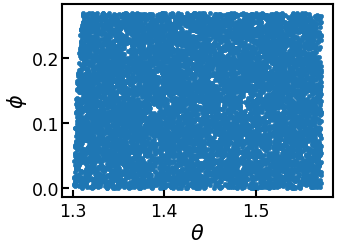

In [14]:
# theta, phi positions of skewers in the sky 
plt.figure(figsize=(7,5), dpi=50);plt.scatter(all_theta, all_phi);plt.xlabel(r'$\theta$');plt.ylabel(r'$\phi$');plt.show()

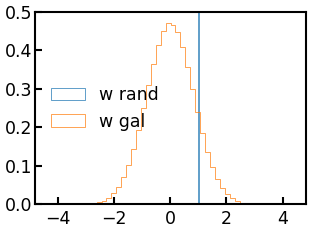

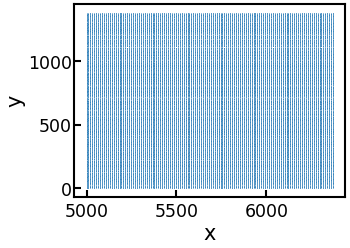

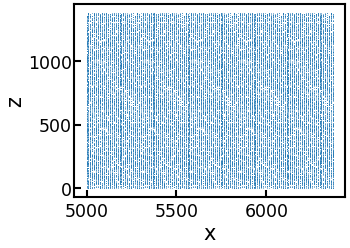

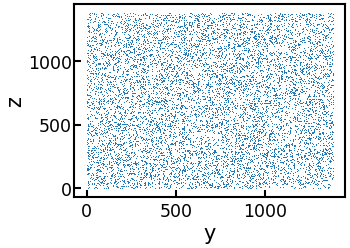

In [15]:
### Plot distribution of weights
plt.figure(figsize=(7,5), dpi=50);
plt.hist(all_w_rand.ravel(),density=True,histtype='step', bins=50, label='w rand');
plt.hist(all_w_gal.ravel(),density=True, histtype='step',bins=50, label='w gal');
plt.ylim(0., 0.5);plt.legend()
plt.show()

#### Visually check if skewers are taken through box
plt.figure(figsize=(7,5), dpi=50);plt.scatter(all_x.ravel()[::100],all_y.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('y');plt.show()
plt.figure(figsize=(7,5), dpi=50);plt.scatter(all_x.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('x');plt.ylabel('z');plt.show()
plt.figure(figsize=(7,5), dpi=50);plt.scatter(all_y.ravel()[::100],all_z.ravel()[::100],s=0.1);plt.xlabel('y');plt.ylabel('z');plt.show()

## compute discrete Fourier transform of matrix $N_{qso} \times N_{pix}$

- compute $\delta_{2D}(\hat{n}_j;k)$ for $\delta_{3D}=\delta_F(\chi\hat{n}_j)$ along each QSO sightline, $\hat{n}_j$, using FFTs [or as matrix-vector multiply of $\exp[ik\chi]$] with $K_j(\chi)\delta_F(\chi)$.
- Since the DESI QSO spectra all share a common wavelength grid, the ``matrix'' can be computed once.  It is convenient to store the real and imaginary parts separately.  
- same procedure on $K_j(\chi)$ not weighted by $\delta_F$ gives $\widetilde{K}_j(k)$.

- use $\delta_{2D}(\hat{n}_j;k)$ as weights for each QSO
- perform a spherical harmonic transform for each $k$
- For $\ell_{\rm max}=10^3$ and $10^6$ QSOs this takes a few seconds for each of the real and imaginary parts for each $k$.  
- Squaring the results and averaging over $m$ gives $C_\ell(k)$, which can be binned into bins of $\ell$ and normalized as desired.  

- compute the window matrix.  This is independent of the data, depending only upon the chosen weights, $K_j(\chi)$, and the QSO positions, $\hat{n}_j$.  If the matrix $\hat{n}_j\cdot\hat{n}_k$ is pre-computed, the sum over $\lambda$ can be done with recurrence relations and the final sum over $jk$ is a matrix product and trace though the final object depends upon $\ell$ (normally binned), $L$ and $k-k'$ and so can be large.  For very large numbers of sightlines, the sum over $j$ can be done in batches using the same procedure.


In [16]:
def compute_dft(chi_grid, mask, delta):
    # Ensure that chi_grid has a uniform step size
    diffs = np.diff(chi_grid)
    dx = diffs[0]
    assert np.allclose(diffs, dx), "Not all values in np.diff(chi_grid) are identical."

    # Number of points
    N = len(chi_grid)

    # Define k-array for Fourier transform
    k_arr = np.fft.fftfreq(N, d=dx)

    FT_mat = dft(N)
    # Perform the DFT using matrix multiplication
    FT_mask  = np.dot(mask, FT_mat)
    FT_delta = np.dot(delta, FT_mat)
    return k_arr, np.real(FT_mask), np.real(FT_delta)

In [17]:
k_arr, FT_mask, FT_delta = compute_dft(chi_grid, all_w_rand, all_w_gal)

### use directSHT to compute $C_{ell}$

In [3]:
import sys
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht-lya/')
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution

try:
    from jax.lib import xla_bridge
    print(xla_bridge.get_backend().platform)
except:
    print("No GPU found")

env: JAX_ENABLE_X64=True
No GPU found


In [4]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 500 , Nx= 1000  and xmax= 0.625
For randoms, Direct SHT has Nl= 564 , Nx= 1000  and xmax= 0.625


In [18]:
tdata,pdata,wdata = all_theta, all_phi, FT_delta
trand,prand,wrand = all_theta, all_phi, FT_mask

In [19]:
print(wrand.shape)
print(prand.shape)

(9797, 512)
(9797,)


In [20]:
# define index for calculation 
k_idx = 0
# To Do: do this in a loop

In [21]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand[:,k_idx])
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
#sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl)# - sn

Sorting & digitizing took  0.0012476444244384766  seconds.
Reshaping took  0.08009147644042969  seconds.
Precomputing vs took  0.5190296173095703  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  5.6715006828308105  seconds.


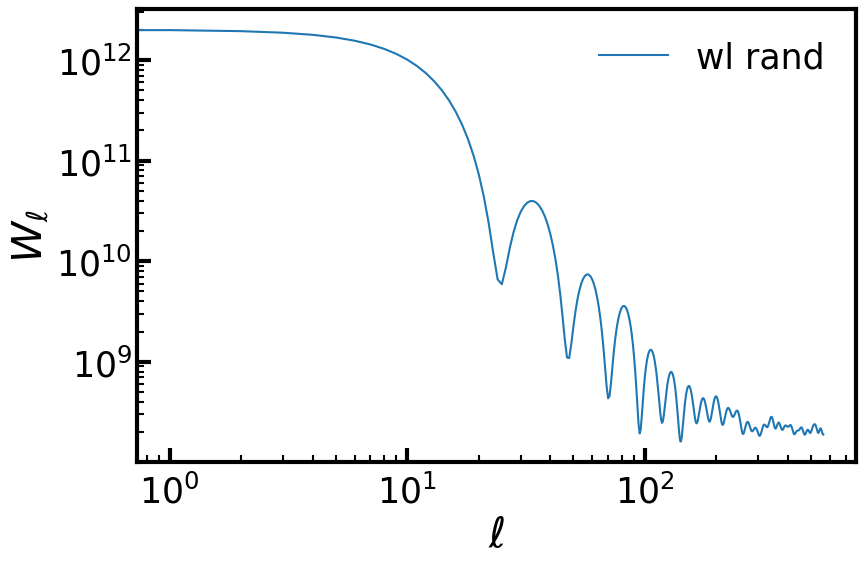

In [22]:
plt.figure(figsize=(9,6))
plt.loglog(wl   ,label='wl rand')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
plt.savefig('./plots/harmonic_window.pdf')

## compute Wigner3j

In [23]:
# if I want to use SHT for the Wigner3j computation
if False:
    # Wigner3j code
    from timeit import default_timer as timer
    import fast_Wigner3j as Wigner3j
    print('use rmvd2 Wigner3j computation')

    #iitialize class
    couple_mat = Wigner3j.CoupleMat(Nl+buffer_ells, wl)
    # time execution code
    start = timer()
    coupling_matrix = couple_mat.compute_matrix()
    end = timer()

    # print elapsed time
    print('elapsed time {:1.5f}s'.format(end - start), flush=True)

    %time MD = MaskDeconvolution(Nl+buffer_ells,wl,precomputed_Wigner=coupling_matrix)

print('use SHT native Wigner3j computation')
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
# NperBin = 10
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

use SHT native Wigner3j computation
Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 2min 48s, sys: 1.33 s, total: 2min 49s
Wall time: 2min 49s

Row sums of Mbl:
[1.00659986 1.00428365 1.00426153 1.00417394 1.00407949 1.00412353
 1.00423574 1.00421268 1.00393216 1.0039339  1.00419584 1.00441683
 1.00451371 1.00412838 1.008592   0.98772718 1.16683054]


### plot coupling matrix and window func

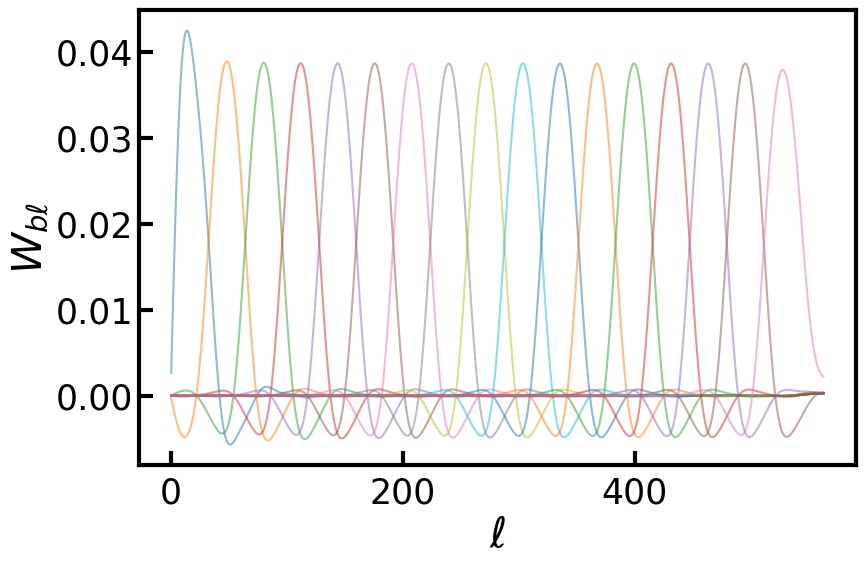

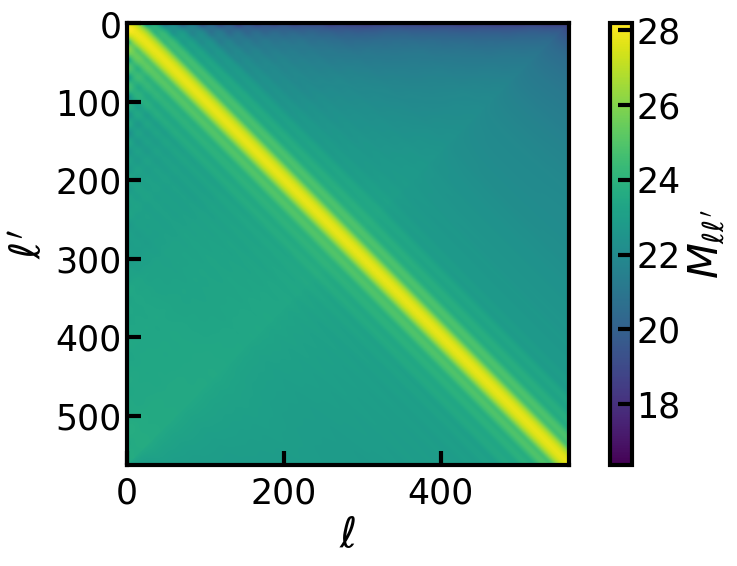

In [24]:
# Plot the matrix:
fig,ax = plt.subplots(1,1, figsize=(9,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
#ax.set_ylim(-0.07, 0.07)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()
plt.savefig('./plots/harmonic_wbl.pdf', bbox_inches='tight')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1, figsize=(9,6))
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
im = ax.imshow(mode_coupling.T)
ax.set_xlabel(r'$\ell$')
fig.colorbar(im, label=r'$M_{\ell \ell^\prime}$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
plt.savefig('./plots/harmonic_mll.pdf', bbox_inches='tight')

### compute $C_{\ell}(k)$ for different values of $k$

In [25]:
cl_k = []
# for k_idx in np.arange(0, 512, 200):
for k_idx in np.arange(0, 50, 15):
    hdat = sht(tdata,pdata,wdata[:,k_idx])
    # Do the same for the randoms.
    hran = sht(trand,prand,wrand[:,k_idx])
    # and for the difference of data and randoms:
    hdif = hp.alm2cl(hdat-hran)
    cl_k.append(hdif)
cl_k = np.stack(cl_k)

Sorting & digitizing took  0.0009999275207519531  seconds.
Reshaping took  0.02386951446533203  seconds.
Precomputing vs took  0.40422558784484863  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.5727100372314453  seconds.
Sorting & digitizing took  0.00110626220703125  seconds.
Reshaping took  0.024199247360229492  seconds.
Precomputing vs took  0.3974120616912842  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.6088814735412598  seconds.
Sorting & digitizing took  0.0010225772857666016  seconds.
Reshaping took  0.02430272102355957  seconds.
Precomputing vs took  0.39675211906433105  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.654010057449341  seconds.
Sorting & digitizing took  0.0010387897491455078  seconds.
Reshaping took  0.02345442771911621  seconds.
Precomputing vs took  0.39777493476867676  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.7609846591949463  seconds.
Sorting & digitizing took  0.0010192394256591797  seconds.
Reshaping took  0.024695634841918945  seconds.
Precomputing vs took  0.4016091823577881  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.7514872550964355  seconds.
Sorting & digitizing took  0.0010318756103515625  seconds.
Reshaping took  0.024129390716552734  seconds.
Precomputing vs took  0.4021165370941162  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.9633982181549072  seconds.
Sorting & digitizing took  0.0010104179382324219  seconds.
Reshaping took  0.0235443115234375  seconds.
Precomputing vs took  0.3990974426269531  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.6718153953552246  seconds.
Sorting & digitizing took  0.0010230541229248047  seconds.
Reshaping took  0.026042699813842773  seconds.
Precomputing vs took  0.412156343460083  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.934998035430908  seconds.


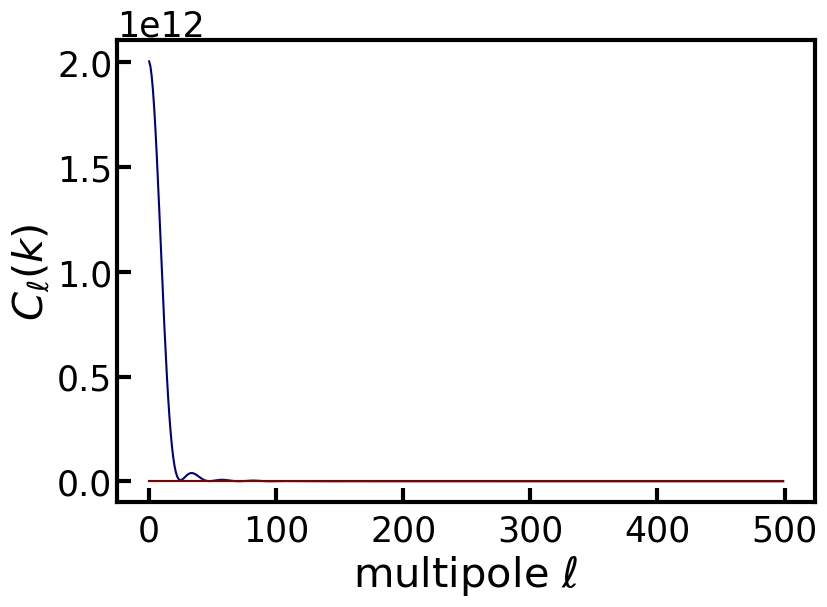

In [26]:
n = len(cl_k)
colors = plt.cm.jet(np.linspace(0,1,n))
plt.figure(figsize=(9,6))
for k_idx in range(len(cl_k)):
    plt.plot(np.arange(sht.Nell), cl_k[k_idx],color=colors[k_idx])
    
plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}(k)$')
plt.show()

In [60]:
k_idx =0
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata[:,k_idx])
# Do the same for the randoms.
hran = sht(trand,prand,wrand[:,k_idx])

hran *= hdat[0]/hran[0]
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
#print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))

Sorting & digitizing took  0.0009982585906982422  seconds.
Reshaping took  0.02280426025390625  seconds.
Precomputing vs took  0.4011118412017822  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.597968101501465  seconds.
Sorting & digitizing took  0.0010089874267578125  seconds.
Reshaping took  0.023435592651367188  seconds.
Precomputing vs took  0.3979604244232178  seconds.


/global/cfs/cdirs/desi/users/rmvd2/software/vega_dmat/lib/python3.12/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Computing alm's took  3.522291660308838  seconds.


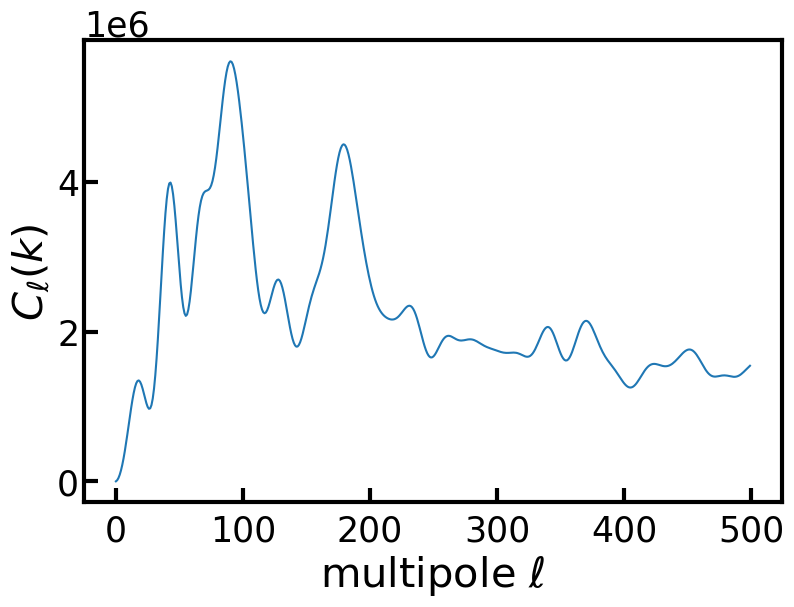

In [61]:
plt.figure(figsize=(9,6)); plt.plot(hdif,label='hdif')
plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}(k)$')
plt.show()

In [29]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [30]:
print(binned_ells)
print(hdif_decoupled)

[ 79.5 111.5 143.5 175.5 207.5 239.5 271.5 303.5 335.5 367.5 399.5 431.5
 463.5]
[ 4.16167332e-04 -8.55387246e-05  1.43951514e-07 -1.28776578e-05
 -8.63700347e-06 -7.59248369e-06 -5.79001345e-06 -5.55475581e-06
 -6.32451394e-06 -6.88028025e-06 -5.32824385e-06 -6.09316150e-06
 -4.87654003e-06]


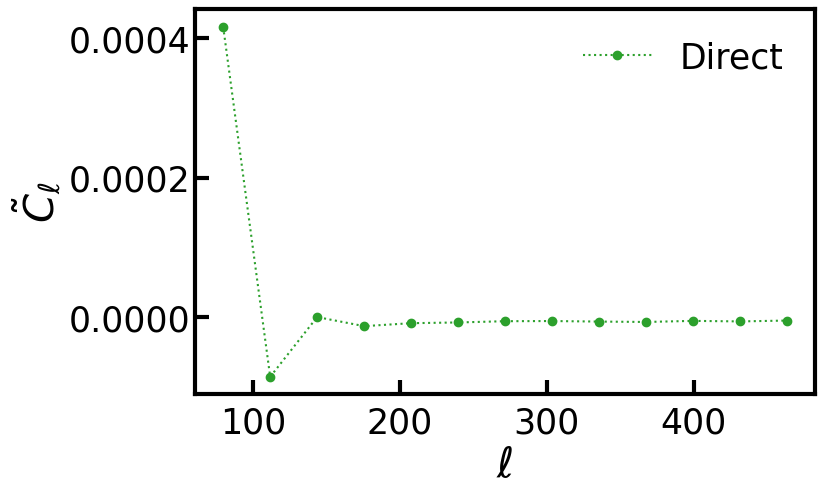

In [31]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
# clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
# ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.savefig('./plots/harmonic_tildeC.pdf', bbox_inches='tight')


# compute theory power spectrum 
$$\Large  C_\ell(k)  = \sum_{L \lambda}  F_{\ell L \lambda} \int\frac{dk'}{2\pi\,\bar{\chi}^2}\ P(L/\bar{\chi},k') \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k-k')\widetilde{K}_k(k-k') $$
Let's compute each element separately and then we'll put it all together
- Let's rewrite this $$\sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k-k')\widetilde{K}_k(k-k') = \sum_{j} \widetilde{K}_j^\star(k-k') \left(\sum_kP_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_k(k-k')\right)$$
- [x] we use the definition of $$ F_{\ell L \lambda} = \frac{(2L+1)(2\lambda+1)}{(4\pi)^2} \begin{pmatrix} \ell & L & \lambda \\ 0&0&0 \end{pmatrix}^2 $$
- [ ] using a periodic box, the $\widetilde{K}_j$ acts like a $\delta$ function
$$ C_\ell(k=0)  = \sum_{L \lambda}  F_{\ell L \lambda} \frac{1}{2\pi\,\bar{\chi}^2}\ P(L/\bar{\chi},k=0) \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k=0)\widetilde{K}_k(k=0) $$
$$ = \sum_{L \lambda} \frac{(2L+1)(2\lambda+1)}{2\pi\,\bar{\chi}^2 \cdot (4\pi)^2} \begin{pmatrix} \ell & L & \lambda \\ 0&0&0 \end{pmatrix}^2  P(L/\bar{\chi},k=0) \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k=0)\widetilde{K}_k(k=0) $$


In [34]:
from scipy.special import eval_legendre
from scipy.integrate import quad
import multiprocessing

In [35]:
def compute_nhat(tdata, pdata):
    """
    Compute the nhat array given tdata and pdata.

    Parameters:
    tdata (np.ndarray): Array of theta data with shape (Nskew,)
    pdata (np.ndarray): Array of phi data with shape (Nskew,)

    Returns:
    np.ndarray: The computed nhat array with shape (Nskew, 3)
    """
    # Compute sin and cos of tdata and pdata
    sin_tdata = np.sin(tdata)
    cos_tdata = np.cos(tdata)
    sin_pdata = np.sin(pdata)
    cos_pdata = np.cos(pdata)

    # Compute nhat
    nhat = np.column_stack((sin_tdata * cos_pdata, sin_tdata * sin_pdata, cos_tdata))
    return nhat

# To Do: use https://numba-special.readthedocs.io/en/latest/index.html to compute the Legendre polynomials quickly


def compute_PLKjKk(lambda_idx,cos_theta_njnk, KjKk):
    """
    Compute PLKjKk given input data.

    Parameters:
    tdata (np.ndarray): Array of theta data with shape (Nskew,)
    pdata (np.ndarray): Array of phi data with shape (Nskew,)
    FT_mask (np.ndarray): Array of FT_mask data with shape (Nskew, 512)
    k_idx (int): Index for the FT_mask (default is 0)
    lambda_idx (int): Index for the Legendre polynomial (default is 0)

    Returns:
    float: The computed PLKjKk value
    """

    # Compute KjKk for one k index
    #KjKk = np.outer(FT_mask[:, k_idx], FT_mask[:, k_idx])

    # Compute Legendre values and PLKjKk
    legendre_vals = eval_legendre(lambda_idx, cos_theta_njnk)
    # DANGEROUS
    # DANGEROUS
    # DANGEROUS
    PLKjKk = np.sum(legendre_vals)*512**2
    # DANGEROUS
    # DANGEROUS
    # DANGEROUS

    return PLKjKk


# def compute_PLKjKk_for_lambda(args):
#     lambda_idx, cos_theta_njnk, KjKk = args
#     return compute_PLKjKk(lambda_idx, cos_theta_njnk, KjKk)


In [36]:
if False:
    if __name__ == "__main__":
        do_parallel = True
        lambda_max = 200
        nhat = compute_nhat(tdata, pdata) # array with 3 cols --> looks sensible
        # Compute cos(theta_nj_nk)
        cos_theta_njnk = np.dot(nhat, nhat.T) # symmetric matrix with shape (Nskew, Nskew)
        KjKk = np.outer(FT_mask[:, k_idx], FT_mask[:, k_idx])
        num_cpus = 20  # Use XX CPUs
    
        if do_parallel:
            # Create a pool of worker processes
            with multiprocessing.Pool(num_cpus) as pool:
                # Prepare arguments for each lambda_idx
                args = [(lambda_idx, cos_theta_njnk, KjKk) for lambda_idx in range(lambda_max)]
                
                # Map the compute_PLKjKk_for_lambda function over the range of lambda values
                PLKjKk = pool.starmap(compute_PLKjKk, args)
        else:
            # Initialize an empty list to collect the results
            PLKjKk = []
    
            # Iterate over each lambda index in series
            for lambda_idx in range(lambda_max):
                result = compute_PLKjKk(lambda_idx, cos_theta_njnk, KjKk)
                PLKjKk.append(result)
    
        PLKjKk = np.array(PLKjKk)
        print('--done--')

In [37]:
#np.savetxt('./data/PLKjKk_lambdamax_500.txt', PLKjKk)

In [38]:
#np.savetxt('./data/PLKjKk_lambdamax_200.txt', PLKjKk)
PLKjKk = np.loadtxt('./data/PLKjKk_lambdamax_200.txt')/Nskew**2
#PLKjKk = np.loadtxt('./data/PLKjKk_lambdamax_500.txt')

In [39]:
#np.savetxt('./data/PLKjKk_lambdamax_200.txt', PLKjKk)

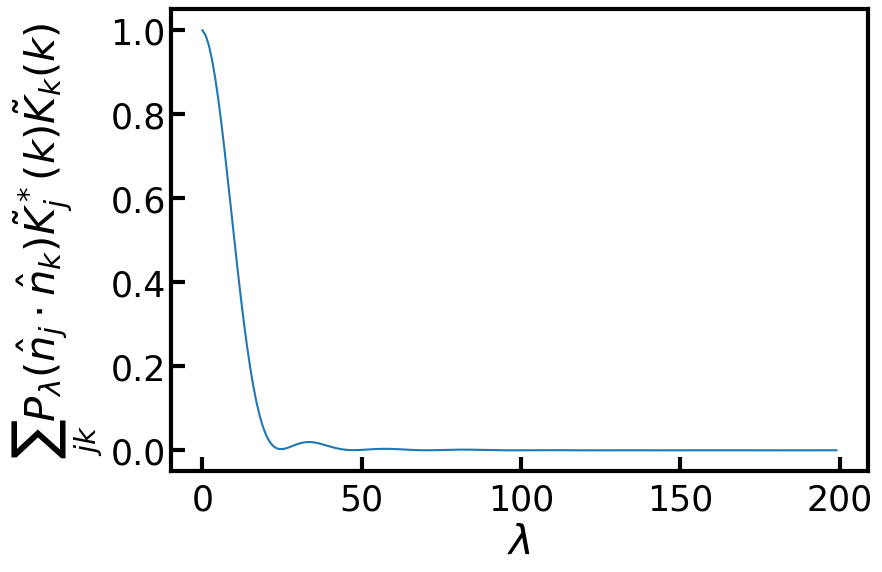

In [69]:
plt.figure(figsize=(9,6))
plt.plot(PLKjKk/512**2/Nskew**2)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\sum_{jk}P_{\lambda}(\hat{n}_j\cdot \hat{n}_k)\tilde{K}_j^*(k)\tilde{K}_k(k)$')
plt.show()

In [70]:
PLKjKk/512**2/Nskew**2

array([1.00000000e+00, 9.88212746e-01, 9.64990923e-01, 9.31024836e-01,
       8.87313079e-01, 8.35120466e-01, 7.75925411e-01, 7.11359461e-01,
       6.43142047e-01, 5.73013696e-01, 5.02670925e-01, 4.33705882e-01,
       3.67553389e-01, 3.05447609e-01, 2.48389896e-01, 1.97128781e-01,
       1.52152314e-01, 1.13692344e-01, 8.17397193e-02, 5.60688438e-02,
       3.62696814e-02, 2.17850071e-02, 1.19506115e-02, 6.03618378e-03,
       3.28475983e-03, 2.94888579e-03, 4.32199923e-03, 6.76393729e-03,
       9.71991501e-03, 1.27327473e-02, 1.54484895e-02, 1.76160206e-02,
       1.90813745e-02, 1.97778257e-02, 1.97128546e-02, 1.89531533e-02,
       1.76087948e-02, 1.58175858e-02, 1.37304730e-02, 1.14986860e-02,
       9.26309935e-03, 7.14609346e-03, 5.24599836e-03, 3.63403935e-03,
       2.35356136e-03, 1.42120660e-03, 8.29651912e-04, 5.51480763e-04,
       5.43764236e-04, 7.52951628e-04, 1.11971804e-03, 1.58347678e-03,
       2.08633219e-03, 2.57631866e-03, 3.00983775e-03, 3.35326623e-03,
      

In [41]:
def Power_spectrum(kh_perp, kh_par):
    kh = np.sqrt(kh_par**2 + kh_perp**2)
    pk = GRF.plin(kh)
    # print(kh, pk)
    return pk

def F_ell_L_lambda(ell, L, lambda_):
    # Compute the prefactor
    prefactor = (2.*L + 1.) * (2.*lambda_ + 1.) / (4. * np.pi)**2
    # Compute the Wigner 3-j symbol
    wigner_3j_value = MD.w3j000(ell, L, lambda_)**2
    return prefactor * wigner_3j_value

def compute_Wigner3j_symmetry_range(j1, j2):
    """
    Compute the range for j3 given j1 and j2: 
    |j1 - j2| <= j3 <= j1 + j2
    """
    return abs(j1 - j2), abs(j1 + j2)

In [42]:

if __name__ == "__main__":
    #ell_range = np.concatenate([np.arange(2, 100, 10)])
    ell_range = np.concatenate([np.arange(2, 100, 1)])

    lambda_max = len(PLKjKk)
    L_min, L_max = compute_Wigner3j_symmetry_range(ell_range.max(), lambda_max)

    k_idx = 0
    Cl_int = np.zeros((len(ell_range), len(k_arr[:k_idx])+1))

    chi_bar = (chi_grid.max()+chi_grid.min())/2
    print('compute for k index:', k_idx, 'with chibar: ', chi_bar)

    # only compute C_ell(k=0) for now
    for ell_idx,ell_val in enumerate(ell_range):
        if ell_val % 20 == 0: print('compute for ell = ', ell_val)
        for L in range(L_min, L_max):
            for lambda_ in range(lambda_max):
                # print('compute for ell = ', ell_val, ' L=', L, 'and lambda=', lambda_)
                Cl_int[ell_idx, k_idx] += F_ell_L_lambda(ell_val, L, lambda_)*Power_spectrum(kh_perp=L/chi_bar, kh_par=k_arr[k_idx])/(2.*np.pi*chi_bar**2) * PLKjKk[lambda_]
    Cl_int = np.array(Cl_int).flatten()

In [181]:
def compute_single_ell(ell_idx, ell_val, L_min, L_max, lambda_max, k_idx, k_arr, chi_bar, PLKjKk):
    result = 0.0
    for L in range(L_min, L_max):
        for lambda_ in range(lambda_max):
            result += (F_ell_L_lambda(ell_val, L, lambda_) * 
                       Power_spectrum(kh_perp=L/chi_bar, kh_par=k_arr[k_idx]) / 
                       (2. * np.pi * chi_bar ** 2) * 
                       PLKjKk[lambda_])
    return ell_idx, result

if __name__ == "__main__":
    # ell_range = np.concatenate([np.arange(2, 100, 10)])
    ell_range = np.concatenate([np.arange(Nl+buffer_ells)])

    lambda_max = len(PLKjKk)
    L_min, L_max = compute_Wigner3j_symmetry_range(ell_range.max(), lambda_max)

    k_idx = 0
    Cl_int = np.zeros((len(ell_range), len(k_arr[:k_idx]) + 1))

    chi_bar = (chi_grid.max() + chi_grid.min()) / 2
    print('compute for k index:', k_idx, 'with chibar: ', chi_bar)

    # Prepare arguments for multiprocessing
    tasks = [(ell_idx, ell_val, L_min, L_max, lambda_max, k_idx, k_arr, chi_bar, PLKjKk) 
             for ell_idx, ell_val in enumerate(ell_range)]

    num_cpu=20
    # Use multiprocessing Pool
    with mp.Pool(num_cpu) as pool:
        results = pool.starmap(compute_single_ell, tasks)

    # Collect results
    for ell_idx, result in results:
        Cl_int[ell_idx, k_idx] = result
    Cl_int = np.array(Cl_int).flatten()
    
    print("Computation completed.")


compute for k index: 0 with chibar:  5690.0
Computation completed.


In [182]:
# np.savetxt('./data/Cl_int_k0_lambdamax_200_ellmax_564.txt', Cl_int)

In [43]:
Cl_int = np.loadtxt('./data/Cl_int_k0_lambdamax_200_ellmax_564.txt')

In [184]:
# np.savetxt('./data/Cl_int_k0_lambdamax_200.txt', Cl_int)

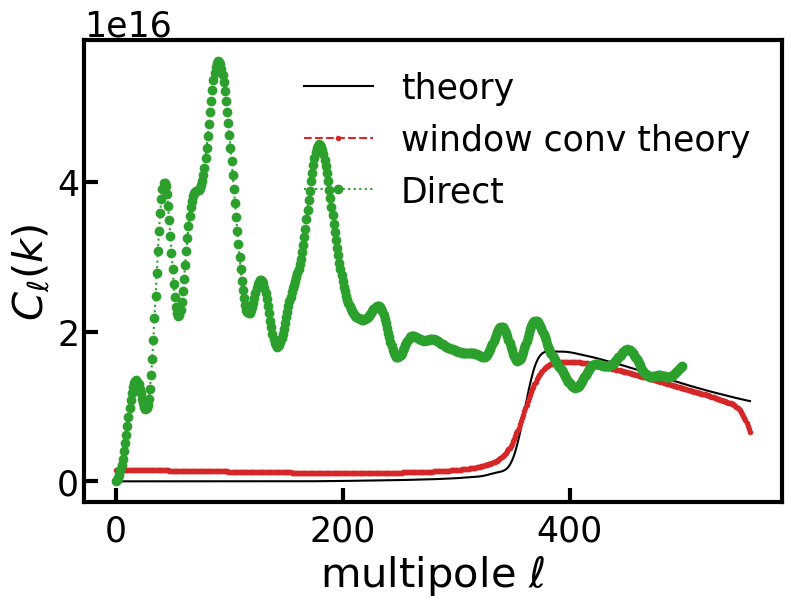

In [64]:
plt.figure(figsize=(9,6))
plt.plot(np.arange(len(Cl_int[Ndiscard:-Ndiscard])), Cl_int[Ndiscard:-Ndiscard],'k-',label='theory')
# Compare to the theory convolved with the bandpower window function
clt_conv = np.dot(MD.Mll,Cl_int[:MD.Mll.shape[1]])/3e+13
plt.plot(clt_conv[Ndiscard:-Ndiscard],'C3.--',label='window conv theory')

plt.plot(hdif*1e+10,'o:',color='C2',label='Direct')

plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}(k)$')
plt.legend()
plt.show()

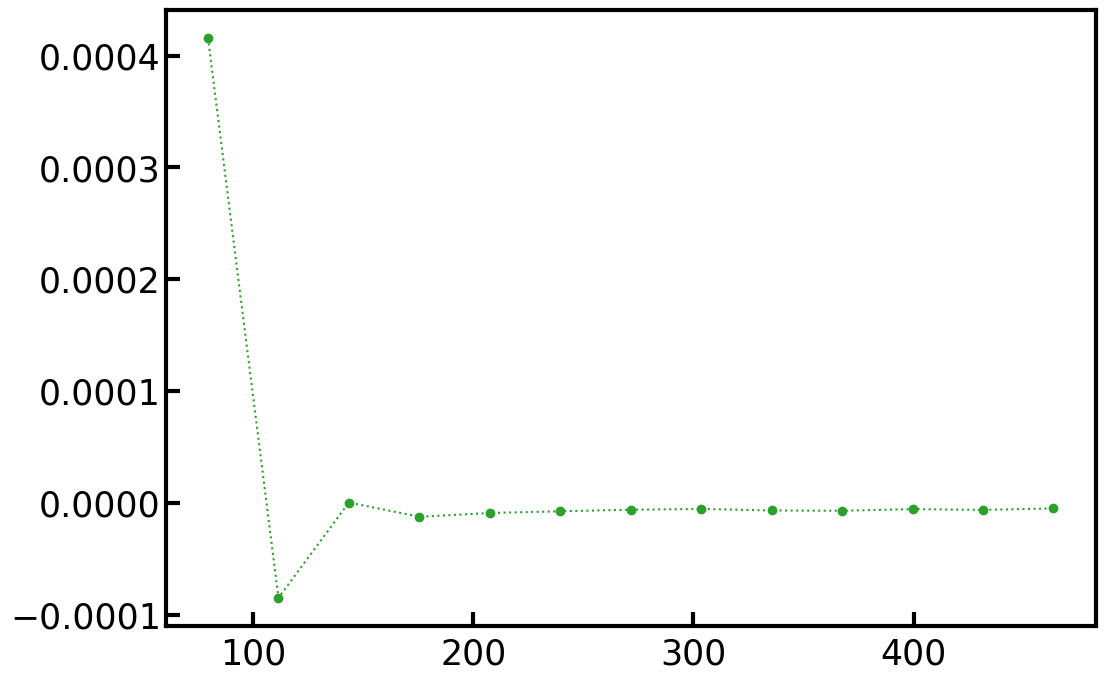

In [195]:
plt.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')